In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

# Алгоритм разделения магнитных аномалий по типам дефектов

**Цель:**
    1. пределить значимые признаки на магнитограммах позволяющие автоматически выявлять магнитные аномалии, вызванные дефектами.
    2. по выявленным значимым признакам предложить алгоритм идентификации дефектных участков трубопроводов по характеру наблюдаемой аномалии.


**Структура данных:**  

**N** – номер измерения  
**Dist** – расстояние от точки старта  
**Xu**, **Yu**, **Zu** – составляющие магнитного поля, зарегистрированные верхним датчиком  
**Xd**, **Yd**, **Zd** – составляющие магнитного поля, зарегистрированные нижним датчиком  
**Vu** – полный вектор магнитного поля по данным верхнего датчика  
**Vd** – полный вектор магнитного поля по данным нижнего датчика  
**LAT** – широта  
**LNG** – долгота  
**Time** – время проведения измерения  
**Depth** – глубина залегания трубопровода (бывает только в некоторых файлах)  
**Mark** – маркер, выставляемый оператором во время съемки  
**Target** – целевая переменная (0 – аномалии в точке нет, 1 – аномалия в точке есть)

### Загрузка данных

Загружаем полевые данные:

In [2]:
df = pd.read_csv('data/150401_0933-0952_(0-915).CSV', sep=';')
df['File'] = 0

In [3]:
df_1 = pd.read_csv('data/150401_1021_(915-2050).CSV', sep=';')
df_1['File'] = 1

In [4]:
df_2 = pd.read_csv('data/150401_1057_(2050-4100).CSV', sep=';')
df_2['File'] = 2

In [5]:
df_3 = pd.read_csv('data/150401_1202_(4116-5828).CSV', sep=';')
df_3['File'] = 3

In [6]:
df = df.append(df_1)
df = df.append(df_2)
df = df.append(df_3)

In [7]:
df['Id'] = range(df.shape[0])

In [8]:
# "Подчищаем" названия столбцов
for i in range(len(df.columns)):
    df.columns.values[i] = df.columns.values[i].lstrip().rstrip()

Первичный анализ даных

In [9]:
df.head()

,N,DIST,Xu,Yu,Zu,Xd,Yd,Zd,Vu,Vd,LAT,LNG,Time,Depth,Mark,Target,File,Id
0,0,0.0,6.4,37.9,-33.2,0.2,30.2,-27.0,50.8,40.5,60.13031,71.6633,9:33:51,0.0,0,0,0,0
1,1,0.0,6.3,37.9,-33.3,0.3,30.2,-27.0,50.9,40.5,60.13031,71.6633,9:33:51,0.0,0,0,0,1
2,2,0.0,6.5,37.9,-33.2,0.3,30.2,-26.9,50.8,40.5,60.13031,71.6633,9:33:51,0.0,0,0,0,2
3,3,1.0,6.5,37.9,-33.2,0.3,30.2,-27.0,50.8,40.5,60.13031,71.6633,9:33:51,0.0,0,0,0,3
4,4,1.0,6.5,37.9,-33.3,0.5,30.2,-26.9,50.8,40.5,60.13031,71.6633,9:33:51,0.0,0,0,0,4


In [10]:
df.shape

(229929, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229929 entries, 0 to 51594
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   N       229929 non-null  int64  
 1   DIST    229929 non-null  float64
 2   Xu      229929 non-null  float64
 3   Yu      229929 non-null  float64
 4   Zu      229929 non-null  float64
 5   Xd      229929 non-null  float64
 6   Yd      229929 non-null  float64
 7   Zd      229929 non-null  float64
 8   Vu      229929 non-null  float64
 9   Vd      229929 non-null  float64
 10  LAT     229929 non-null  float64
 11  LNG     229929 non-null  float64
 12  Time    229929 non-null  object 
 13  Depth   229929 non-null  float64
 14  Mark    229929 non-null  int64  
 15  Target  229929 non-null  int64  
 16  File    229929 non-null  int64  
 17  Id      229929 non-null  int32  
dtypes: float64(12), int32(1), int64(4), object(1)
memory usage: 32.5+ MB


In [12]:
df.to_csv('data/result_data.csv', index=False, encoding='utf-8')

### 1. Обзор данных

__Обзор целевой переменной__

In [13]:
df['Target'].value_counts()

0    229885
1        44
Name: Target, dtype: int64

__Обзор количественных признаков__

In [14]:
df.describe()

,N,DIST,Xu,Yu,Zu,Xd,Yd,Zd,Vu,Vd,LAT,LNG,Depth,Mark,Target,File,Id
count,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.000000,229929.00000
mean,31766.621274,2853.445484,5.338654,7.557555,-58.296179,6.357171,8.041033,-56.510912,60.193650,58.660774,60.111763,71.637174,209.604310,0.019541,0.000191,1.666410,114964.00000
std,21732.698286,2931.434148,7.451277,8.820071,3.716310,7.630994,8.865570,4.177925,2.816054,3.429483,0.011538,0.014814,30.570165,0.844493,0.013832,1.002439,66374.92936
min,0.000000,0.000000,-37.200000,-53.000000,-82.100000,-35.500000,-52.700000,-84.700000,39.200000,33.300000,60.087780,71.613970,0.000000,0.000000,0.000000,0.000000,0.00000
25%,14370.000000,1314.400000,0.400000,2.100000,-60.200000,1.300000,2.500000,-58.400000,58.600000,56.800000,60.103480,71.624320,194.900000,0.000000,0.000000,1.000000,57482.00000
50%,28741.000000,2551.500000,5.000000,8.000000,-58.400000,6.000000,8.500000,-56.400000,59.800000,58.000000,60.112960,71.637130,209.400000,0.000000,0.000000,2.000000,114964.00000
75%,44691.000000,3910.700000,9.700000,13.400000,-56.600000,10.900000,14.000000,-54.600000,61.500000,60.100000,60.121360,71.650050,225.500000,0.000000,0.000000,2.000000,172446.00000
max,88409.000000,50133.000000,44.400000,47.600000,-22.500000,45.800000,49.100000,-21.600000,82.900000,86.000000,60.130310,71.663310,352.300000,60.000000,1.000000,3.000000,229928.00000


### 2. Обработка пропусков

In [15]:
len(df) - df.count()

N         0
DIST      0
Xu        0
Yu        0
Zu        0
Xd        0
Yd        0
Zd        0
Vu        0
Vd        0
LAT       0
LNG       0
Time      0
Depth     0
Mark      0
Target    0
File      0
Id        0
dtype: int64

Пропусков нет.

### 3. Обработка выбросов

In [16]:
def emissions(data):
    # Считаем диапазон за границами которого все выброс.    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [17]:
def build_regressor_outlier(df, columns, field):
    # Обучили регрессор.
    X = df[columns]
    y = df[field]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [18]:
def clear_outlier(data, field, columns):
    # Обрабатываем выброс для конкретного поля.
    r_1, r_2 = emissions(data[field])
    if r_1 - r_2 != 0:
        share = round(data[(r_1 > data[field]) | (data[field] > r_2)].size/data.size*100, 2)
        print(f'"{field}"\nОбщая доля выбросов в процентах {share}%\n')
        if share > 5:
            model = build_regressor_outlier(data[(r_1 < data[field]) & (data[field] < r_2)], columns, field)
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = predict_regressor_outlier(data[(r_1 > data[field]) | (data[field] > r_2)], model, columns, field)
        else:
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = data[(r_1 < data[field]) & (data[field] < r_2)][field].mode()[0]

In [19]:
def predict_regressor_outlier(df, model, columns, filed):
    # Получили значения для пустых значений.
    X = df[columns]
    y = model.predict(X)
    return y

In [20]:
def clear_outlier_all(data, columns):
    # Обрабатываем выбросы для всех полей конкретной выборки
    clear_outlier(data, 'Xu', columns)
    clear_outlier(data, 'Yu', columns)
    clear_outlier(data, 'Zu', columns)
    clear_outlier(data, 'Xd', columns)
    clear_outlier(data, 'Yd', columns)
    clear_outlier(data, 'Zd', columns)
    clear_outlier(data, 'Vu', columns)
    clear_outlier(data, 'Vd', columns)
    clear_outlier(data, 'Depth', columns)

In [21]:
columns = ['N', 'DIST', 'Xu', 'Yu', 'Zu', 'Xd', 'Yd', 'Zd', 'Vu', 'Vd', 'LAT', 'LNG', 'Depth', 'Mark', 'Target', 'File', 'Id']

In [22]:
clear_outlier_all(df, columns)

"Xu"
Общая доля выбросов в процентах 1.93%

"Yu"
Общая доля выбросов в процентах 1.51%

"Zu"
Общая доля выбросов в процентах 5.06%

"Xd"
Общая доля выбросов в процентах 1.81%

"Yd"
Общая доля выбросов в процентах 1.32%

"Zd"
Общая доля выбросов в процентах 6.78%

"Vu"
Общая доля выбросов в процентах 4.74%

"Vd"
Общая доля выбросов в процентах 5.8%

"Depth"
Общая доля выбросов в процентах 4.87%



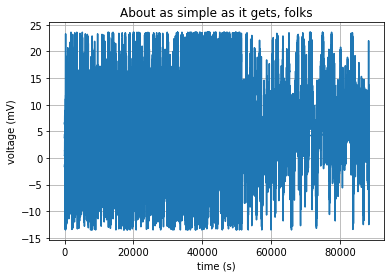

In [23]:
fig, ax = plt.subplots()
ax.plot(df['N'], df['Xu'])

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

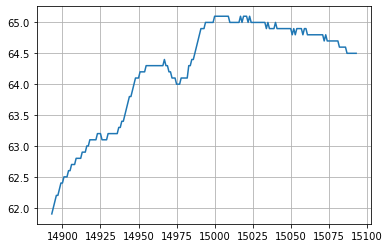

In [40]:
df_1 = df.loc[(df['N'] >= 14893) & (df['N'] <= 15093) & (df['File'] == 0)]

fig, ax = plt.subplots()
ax.plot(df_1['N'], df_1['Vu'])

ax.grid()

# fig.savefig("test.png")
plt.show()

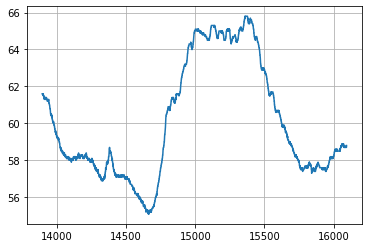

In [41]:
df_1 = df.loc[(df['N'] >= 13893) & (df['N'] <= 16093) & (df['File'] == 0)]

fig, ax = plt.subplots()
ax.plot(df_1['N'], df_1['Vu'])

ax.grid()

# fig.savefig("test.png")
plt.show()

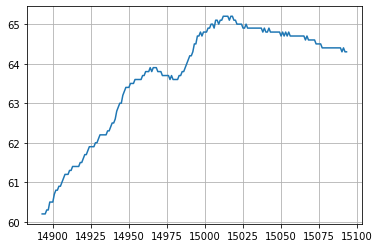

In [42]:
df_1 = df.loc[(df['N'] >= 14893) & (df['N'] <= 15093) & (df['File'] == 0)]

fig, ax = plt.subplots()
ax.plot(df_1['N'], df_1['Vd'])

ax.grid()

# fig.savefig("test.png")
plt.show()

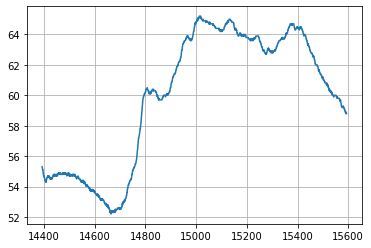

In [43]:
df_1 = df.loc[(df['N'] >= 14393) & (df['N'] <= 15593) & (df['File'] == 0)]

fig, ax = plt.subplots()
ax.plot(df_1['N'], df_1['Vd'])

ax.grid()

# fig.savefig("test.png")
plt.show()